In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio
from tqdm import tqdm

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/pathlength_tuning/1_code/')
from func import set_proj_env, my_get_cmap, rank_int

/Users/lindenmp/opt/anaconda3/envs/pfactor_gradients/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
parc_str = 'schaefer' # 'schaefer' 'lausanne' 'glasser'
parc_scale = 400 # 200/400 | 125/250 | 360
edge_weight = 'streamlineCount' # 'streamlineCount' 'volNormStreamline'
set_proj_env()

('/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/0_data',
 '/Volumes/work_ssd/research_data/PNC/',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/3_output')

In [4]:
# output file prefix
outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_'
outfile_prefix

'schaefer_400_streamlineCount_'

### Setup directory variables

In [5]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline


In [6]:
storedir = os.path.join(os.environ['PIPELINEDIR'], '6_repl_prediction', 'store')
print(storedir)
if not os.path.exists(storedir): os.makedirs(storedir)
    
outputdir = os.path.join(os.environ['PIPELINEDIR'], '6_repl_prediction', 'out')
print(outputdir)
if not os.path.exists(outputdir): os.makedirs(outputdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline/6_repl_prediction/store
/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline/6_repl_prediction/out


In [7]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/3_output/figs


### Parameters

In [8]:
control_list = ['minimum','minimum_taylor']; control = control_list[0]
T_list = [1,]; T = T_list[0]
B_list = ['x0xfwb',]; B_ver = B_list[0]

num_parcels=parc_scale
n_clusters=int(num_parcels*.05)
print(n_clusters)
n_subsamples = 20

20


#### Get indices of elements

In [9]:
# indices = np.triu_indices(n_clusters, k=1)
# indices = np.tril_indices(n_clusters, k=-1)
indices = np.where(~np.eye(n_clusters,dtype=bool))
len(indices[0])

380

In [10]:
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear','F1_Exec_Comp_Res_Accuracy','F3_Executive_Efficiency','Overall_Speed']
pheno = phenos[0]
print(pheno)

Overall_Psychopathology


### Setup plots

In [11]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'talk', font_scale = 1)
cmap = my_get_cmap('pair')

## Load data

In [12]:
df = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '0_get_sample', 'out', outfile_prefix+'df.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)
df = df.loc[df['disc_repl'] == 1,:]
print(df.shape)

(458, 59)


## Energy

In [13]:
# subject filter
subj_filt = np.zeros((df.shape[0],)).astype(bool)

In [14]:
covs = ['mprage_antsCT_vol_TBV', 'dti64MeanRelRMS']

E = np.zeros((n_clusters, n_clusters, n_subsamples, df.shape[0]))
Eto = np.zeros((n_clusters, n_clusters, n_subsamples, df.shape[0]))

for i in tqdm(np.arange(df.shape[0])):
    subjid = str(df.iloc[i].name[0])+'_'+str(df.iloc[i].name[1])
    file_label = subjid+'_T-'+str(T)+'_B-'+B_ver+'-g'+str(n_clusters)
    if i == 0: print(file_label)
    
    try:
        E[:,:,:,i] = np.load(os.path.join(os.environ['PIPELINEDIR'], '5_compute_minimum_energy_taylor_optimized', 'out', outfile_prefix[:-1], pheno+'_'+'_'.join(covs),
                                          file_label+'_E.npy'))
        
        Eto[:,:,:,i] = np.load(os.path.join(os.environ['PIPELINEDIR'], '5_compute_minimum_energy_taylor_optimized', 'out', outfile_prefix[:-1], pheno+'_'+'_'.join(covs),
                                          file_label+'_Eto.npy'))
    except:
        print(subjid + ': NOT FOUND')
        subj_filt[i] = True

  6%|▋         | 29/458 [00:00<00:01, 280.18it/s]

81754_2740_T-1_B-x0xfwb-g20


100%|██████████| 458/458 [00:01<00:00, 433.50it/s]


In [15]:
np.sum(subj_filt)

0

In [16]:
if any(subj_filt):
    E = E[:,:,:,~subj_filt]
    Eto = Eto[:,:,:,~subj_filt]
    df = df.loc[~subj_filt]

In [17]:
# mean over subsamples
E = np.mean(E, axis = 2)
Eto = np.mean(Eto, axis = 2)
print(E.shape)
print(Eto.shape)

(20, 20, 458)
(20, 20, 458)


## Normalize

In [18]:
# normalize
for i in tqdm(np.arange(n_clusters)):
    for j in np.arange(n_clusters):
        if i != j:
            E[i,j,:] = rank_int(pd.Series(data=E[i,j,:])).values
            Eto[i,j,:] = rank_int(pd.Series(data=Eto[i,j,:])).values            

100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


In [19]:
# Y
# df.loc[:,pheno] = rank_int(df.loc[:,pheno])

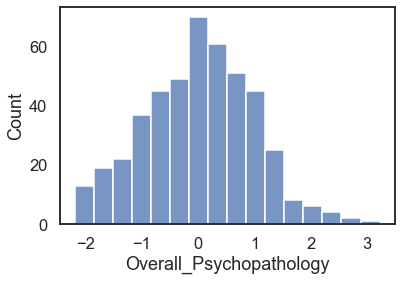

In [20]:
sns.histplot(df[pheno])

In [21]:
df['sex_adj'] = df['sex'] - 1
covs = ['sex_adj', 'ageAtScan1_Years', 'mprage_antsCT_vol_TBV', 'dti64MeanRelRMS']

In [22]:
df.loc[:,'dti64MeanRelRMS'] = rank_int(df.loc[:,'dti64MeanRelRMS'])

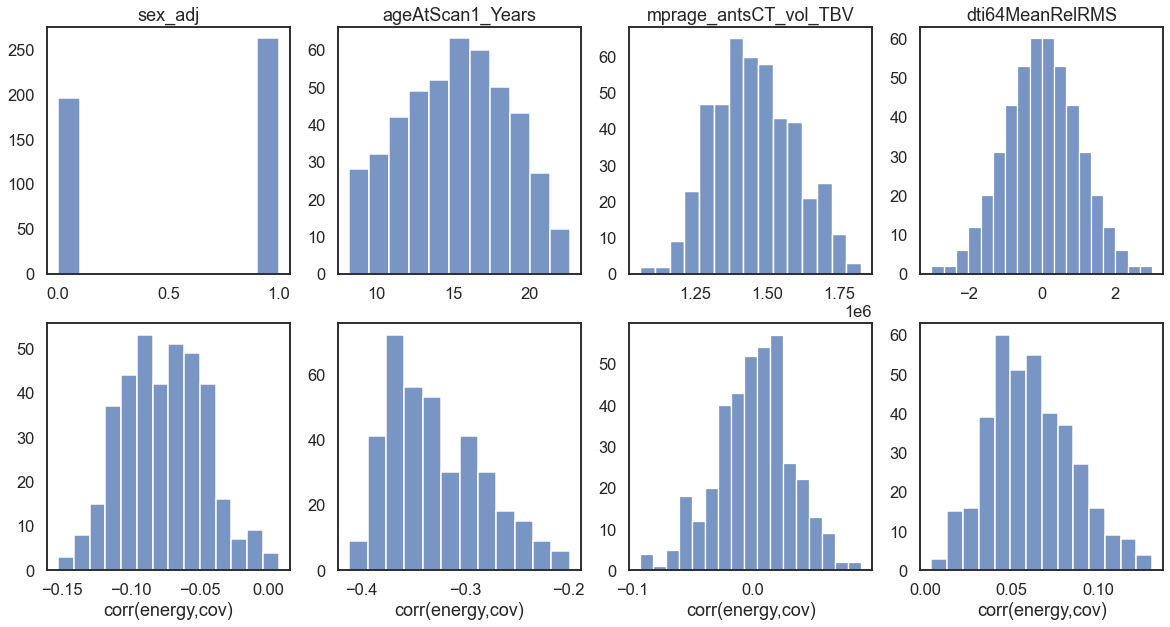

In [23]:
if len(covs) > 0:
    f, ax = plt.subplots(2, len(covs), figsize=(len(covs)*5, 10))
    
    for c, cov in enumerate(covs):
        r_cov = np.zeros((n_clusters,n_clusters))
        
        for i in np.arange(n_clusters):
            for j in np.arange(n_clusters):
                if i != j:
                    r_cov[i,j] = sp.stats.pearsonr(df.loc[:,cov],E[i,j,:])[0]
                         
        ax[0,c].set_title(cov)
        sns.histplot(df.loc[:,cov], ax=ax[0,c])
        ax[0,c].set_ylabel('')
        ax[0,c].set_xlabel('')
        sns.histplot(r_cov[indices], ax=ax[1,c])
        ax[1,c].set_xlabel('corr(energy,cov)')
        ax[1,c].set_ylabel('')

## Save out

In [24]:
num_elements = len(indices[0])

column_labels = []
for i in np.arange(num_elements): column_labels.append('E_i'+str(indices[0][i])+'j'+str(indices[1][i]))
df_E = pd.DataFrame(data = E[indices].transpose(), index = df.index, columns = column_labels)

column_labels = []
for i in np.arange(num_elements): column_labels.append('Eto_i'+str(indices[0][i])+'j'+str(indices[1][i]))
df_Eto = pd.DataFrame(data = Eto[indices].transpose(), index = df.index, columns = column_labels)

df_X = pd.concat((df_E,df_Eto), axis = 1)

In [25]:
# export for prediction models
df_X.to_csv(os.path.join(storedir, outfile_prefix+pheno+'_X.csv'))
# df_E.to_csv(os.path.join(storedir, outfile_prefix+pheno+'_E.csv'))
# df_Eto.to_csv(os.path.join(storedir, outfile_prefix+pheno+'_Eto.csv'))

df.loc[:,phenos].to_csv(os.path.join(storedir, outfile_prefix+'y.csv'))

covs = ['sex_adj', 'ageAtScan1_Years', 'mprage_antsCT_vol_TBV', 'dti64MeanRelRMS']
df.loc[:,covs].to_csv(os.path.join(storedir, outfile_prefix+'c_'+'_'.join(covs)+'.csv'))